In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_palette('deep')
sns.set_palette([sns.color_palette()[i] for i in [0,1,2,3,4,9,7]])

First, we import the dataset as a DataFrame and observe the features.

In [2]:
data = pd.read_csv('Datasets/train_r1.csv')
data

altitude  exposure  ground_slant  water_distance  water_altitude  \
0           2596        51             3             258               0   
1           2804       139             9             268              65   
2           2785       155            18             242             118   
3           2595        45             2             153              -1   
4           2579       132             6             300             -15   
...          ...       ...           ...             ...             ...   
464805      2405       159            22              90              19   
464806      2391       152            19              67              12   
464807      2386       159            17              60               7   
464808      2384       170            15              60               5   
464809      2383       165            13              60               4   

        path_distance  morning_shade  midday_shade  evening_shade  \
0                 510            221           232            148   
1                3180            234           238            135   
2                3090            238           238            122   
3                 391            220           234            150   
4                  67            230           237            140   
...               ...            ...           ...            ...   
464805            120            237           238            119   
464806             95            240           237            119   
464807             90            236           241            130   
464808             90            230           245            143   
464809             67            231           244            141   

        fire_distance  wilderness_area_class  soil_class  forest_canopy  
0                6279                      1          29              5  
1                6121                      1          12              2  
2                6211                      1          30              2  
3                6172                      1          29              5  
4                6031                      1          29              2  
...               ...                    ...         ...            ...  
464805            824                      3           2              3  
464806            845                      3           2              3  
464807            854                      3           2              3  
464808            864                      3           2              3  
464809            875                      3           2              3  

[464810 rows x 13 columns]

We use the `count()` method to see whether the dataset has any missing values. 

In [3]:
{c : data[c].count() for c in data.columns}

{'altitude': 464810,
 'exposure': 464810,
 'ground_slant': 464810,
 'water_distance': 464810,
 'water_altitude': 464810,
 'path_distance': 464810,
 'morning_shade': 464810,
 'midday_shade': 464810,
 'evening_shade': 464810,
 'fire_distance': 464810,
 'wilderness_area_class': 464810,
 'soil_class': 464810,
 'forest_canopy': 464810}

Given that there are no missing values, we proceed to select the feature to be predicted as the `Y_feature`, and partition the dataframe into X and Y values. Our goal is to classify data points into the classes of the categorical variable `forest_canopy`.

In [4]:
Y_feature = 'forest_canopy'
Y = data[Y_feature]
N = len(data[Y_feature].unique())
X = data.drop(columns=[Y_feature])

## Preliminary evaluation of the dataset

Before executing any machine learning algorithms, we shall study the dataset through qualitative observations in order to make some preliminary observations, and make possible optimizations to the machine learning model if necessary. 

The simplest preliminary analysis that can be made is to search for single variables that could be correlated with the forest canopy class, since `forest_canopy` is a categorical feature, we make use of partitioned histograms to perform the analysis.

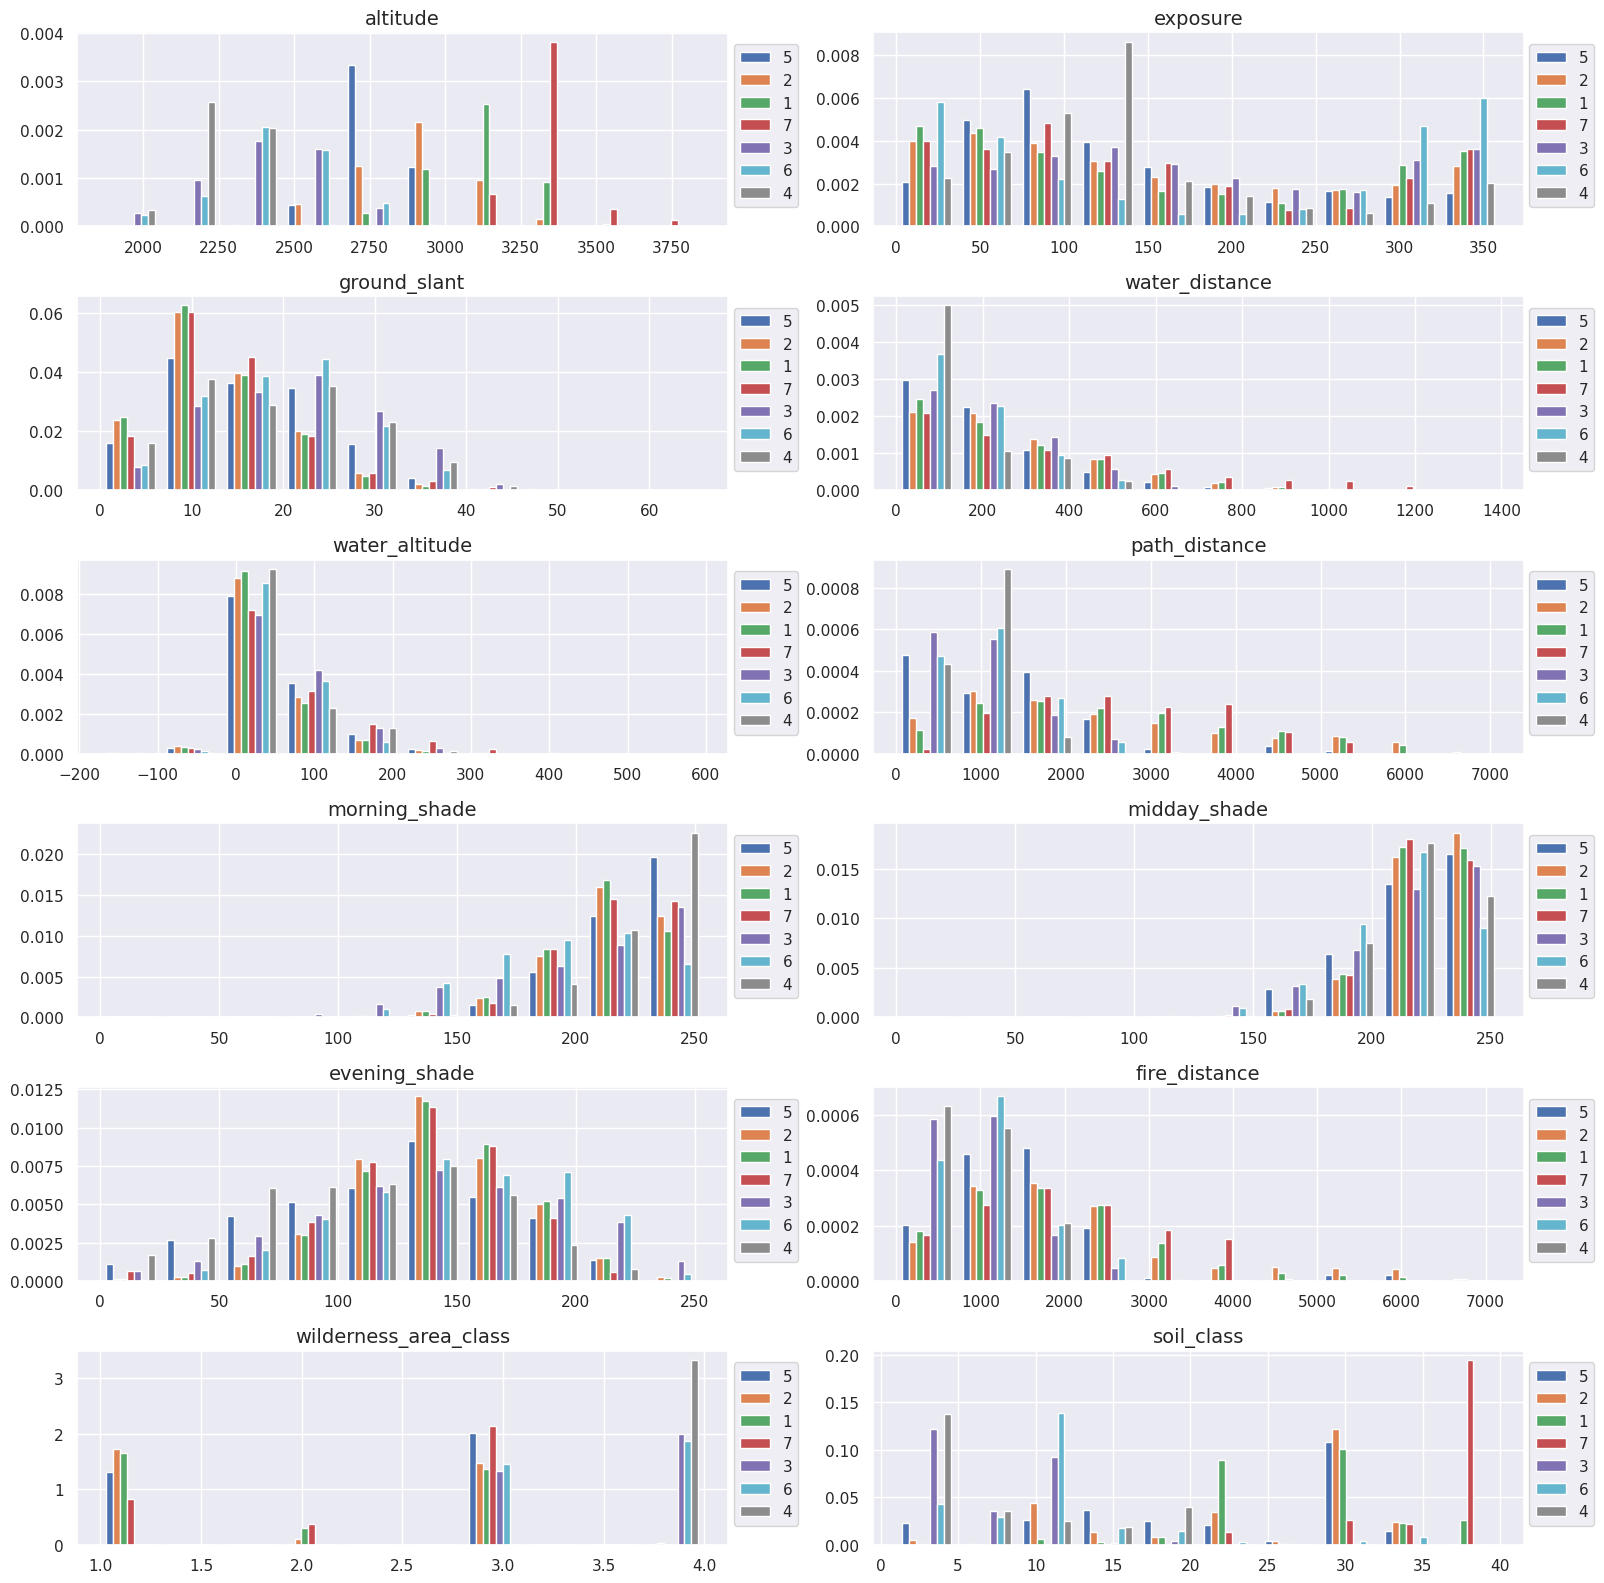

In [5]:
plt.rcParams["figure.figsize"] = (16,16)
plt.rcParams["lines.markersize"] = 0.25
fig, axs = plt.subplots(6,2)

k = 0
for i in range(0,6):
    for j in range(0,2):
        feat = X.columns[k]
        sel = [data[data[Y_feature]==i][feat] for i in data[Y_feature].unique()]
        axs[i,j].hist(sel, density=True)
        axs[i,j].title.set_text(feat)
        axs[i,j].title.set_fontsize(14)
        axs[i,j].legend(data[Y_feature].unique(), loc='lower right', bbox_to_anchor=(1.12,0.06))
        k+=1
plt.tight_layout()

From the histograms only, some preliminary observations can be made:

- The `altitude` feature is highly impactful for all classes
- A low `ground_slant` value favors classes **5**, **2**, **1**, and **7**, while higher `ground_slant` values favors classes **3**, **6**, and **4**
- Low values in `path_distance` or `fire_distance` favor classes **3**, **6**, and **4**
- The `water_height` feature does not seem to be strongly correlated with the outcome
- High `evening_shade` values favor classes **6** and **4**, medium `evening_shade` values favor classes **2**, **1**, and **7**, low `evening_shade` values favor classes **5** and **4**
- High `morning_shade` values strongly favor classes **5** and **4**, low `morning_shade` values reject all classes except **3** and **6**
- The categorical features `wilderness_area` and `soil_class` are highly impactful 

Since altitude appears to be the feature most strongly correlated with the forest canopy class, we can search for potential two-variable correlations of altitude and some other feature with our target feature. We do this by means of color-coded scatter plots.

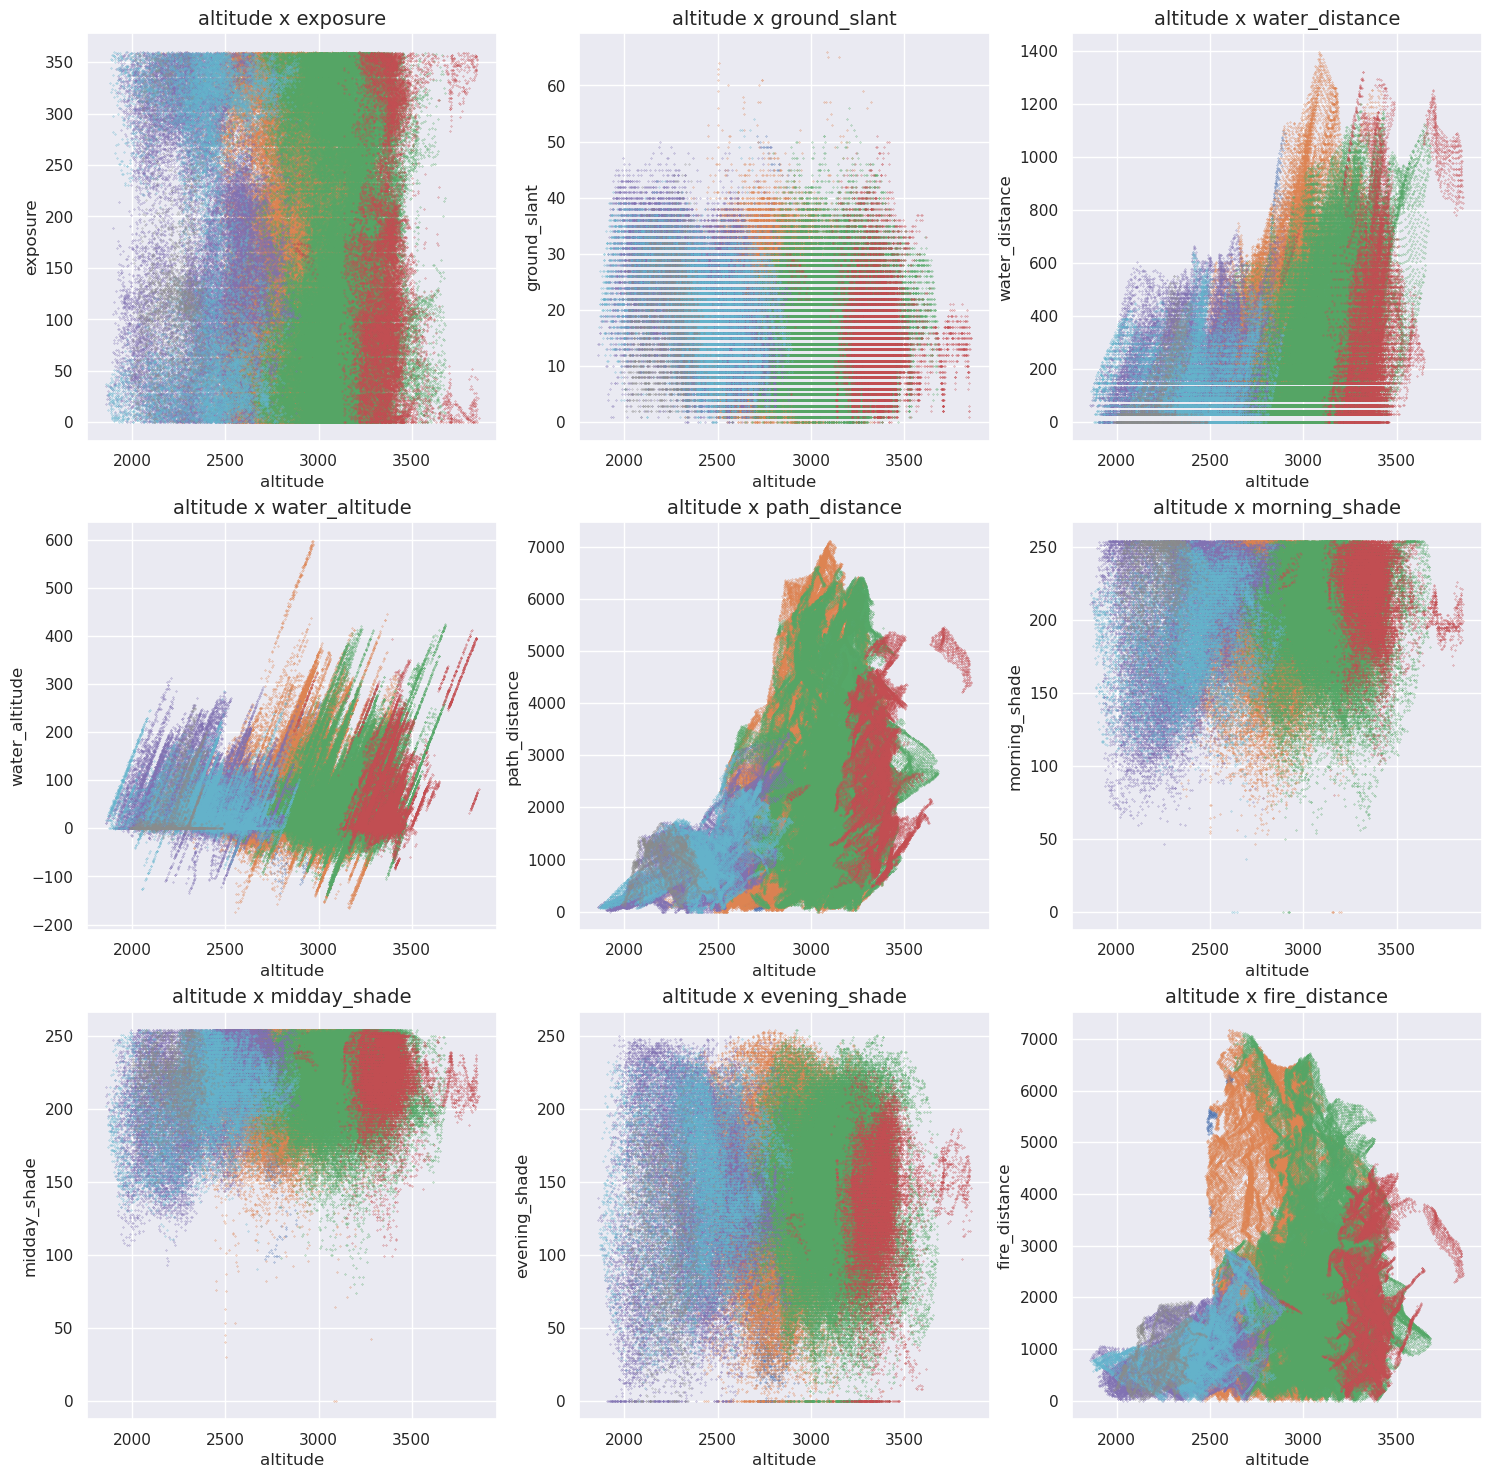

In [6]:
plt.rcParams["figure.figsize"] = (18,18)

def plt_scatter(ax, feature1, feature2):
    for i in data[Y_feature].unique():
        ax.scatter(data[data[Y_feature]==i][feature1], data[data[Y_feature]==i][feature2])
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.title.set_fontsize(14)
    ax.title.set_text(f"{feature1} x {feature2}")

def plt_scatters(xfeature):
    fig, axs = plt.subplots(3,3)
    k = 0
    for i in range(0,3):
        for j in range(0,3):
            if X.columns[k] == xfeature:
                k+=1
            feat = X.columns[k]
            plt_scatter(axs[i,j], xfeature, feat)
            k+=1
plt_scatters('altitude')

On several of the resultant plots we can observe how islands of each forest canopy class emerge. In most cases the islands are visibly non-linear, making decision tree type classifiers a good choice of model. 

In [7]:
data.loc[:, 'altitude':'fire_distance'].corr()

altitude  exposure  ground_slant  water_distance  \
altitude        1.000000  0.015627     -0.242346        0.306777   
exposure        0.015627  1.000000      0.078566        0.017738   
ground_slant   -0.242346  0.078566      1.000000       -0.009889   
water_distance  0.306777  0.017738     -0.009889        1.000000   
water_altitude  0.093571  0.070563      0.275606        0.606318   
path_distance   0.365529  0.023956     -0.215175        0.072223   
morning_shade   0.112444 -0.578088     -0.326536       -0.027504   
midday_shade    0.207164  0.336245     -0.527472        0.046974   
evening_shade   0.059673  0.645929     -0.176948        0.052679   
fire_distance   0.148737 -0.109803     -0.185550        0.051130   

                water_altitude  path_distance  morning_shade  midday_shade  \
altitude              0.093571       0.365529       0.112444      0.207164   
exposure              0.070563       0.023956      -0.578088      0.336245   
ground_slant          0.275606      -0.215175      -0.326536     -0.527472   
water_distance        0.606318       0.072223      -0.027504      0.046974   
water_altitude        1.000000      -0.045929      -0.166288     -0.110821   
path_distance        -0.045929       1.000000       0.035031      0.189243   
morning_shade        -0.166288       0.035031       1.000000      0.010542   
midday_shade         -0.110821       0.189243       0.010542      1.000000   
evening_shade         0.034845       0.105340      -0.779955      0.594267   
fire_distance        -0.070564       0.332005       0.133187      0.057608   

                evening_shade  fire_distance  
altitude             0.059673       0.148737  
exposure             0.645929      -0.109803  
ground_slant        -0.176948      -0.185550  
water_distance       0.052679       0.051130  
water_altitude       0.034845      -0.070564  
path_distance        0.105340       0.332005  
morning_shade       -0.779955       0.133187  
midday_shade         0.594267       0.057608  
evening_shade        1.000000      -0.048222  
fire_distance       -0.048222       1.000000

Observing the correlation matrix allows us to notice which features might be meaningfully (linearly) correlated or anti-correlated. 

The following feature pairs display a correlation of $R>0.5$ or $R<-0.5$

| Feature | Correlated with |
| --- | --- |
| `exposure      ` | `morning_shade, evening_shade` |
| `ground_slant  ` | `midday_shade`                 |
| `water_distance` | `water_altitude`               |
| `evening_shade ` | `morning_shade, midday_shade`  |


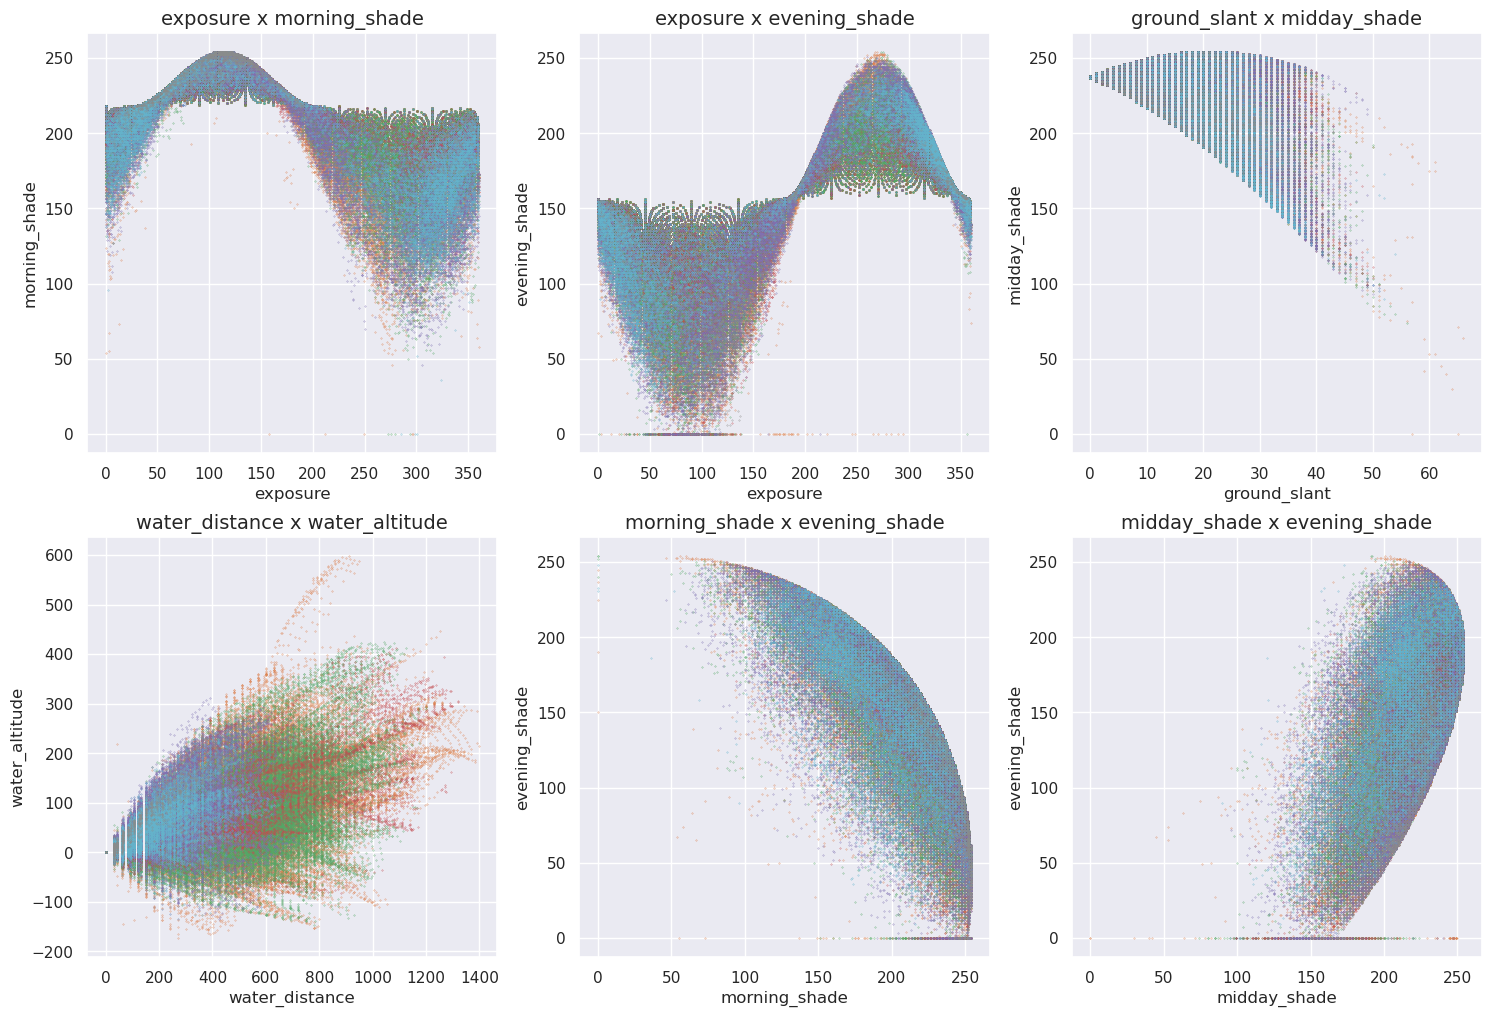

In [8]:
plt.rcParams["figure.figsize"] = (18,12)
fig, axs = plt.subplots(2,3)
plt_scatter(axs[0,0], 'exposure', 'morning_shade')
plt_scatter(axs[0,1], 'exposure', 'evening_shade')
plt_scatter(axs[0,2], 'ground_slant', 'midday_shade')
plt_scatter(axs[1,0], 'water_distance', 'water_altitude')
plt_scatter(axs[1,1], 'morning_shade', 'evening_shade')
plt_scatter(axs[1,2], 'midday_shade', 'evening_shade')

## Preprocessing of Dataset

Given that we will use algorithms in the tree family that do not rely on notions of distance between datapoints, there is no need to normalize or otherwise scale the numerical features. 

For the categorical features, there is no reason to assume an incremental nature to the classes, so we will transform them from ordinal encoding to one-hot encoding.

In [9]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)

cat_data = X.loc[:, 'wilderness_area_class':'soil_class']
enc_data = enc.fit_transform(cat_data)

labels = [f'{cat_data.columns[i]}_{j}' for i in [0, 1] for j in enc.categories_[i]]
cat_df = pd.DataFrame(columns=labels, data=enc_data)
num_df = X.loc[:, 'altitude':'fire_distance']

ready_X = pd.concat([num_df, cat_df], axis=1)
ready_X

altitude  exposure  ground_slant  water_distance  water_altitude  \
0           2596        51             3             258               0   
1           2804       139             9             268              65   
2           2785       155            18             242             118   
3           2595        45             2             153              -1   
4           2579       132             6             300             -15   
...          ...       ...           ...             ...             ...   
464805      2405       159            22              90              19   
464806      2391       152            19              67              12   
464807      2386       159            17              60               7   
464808      2384       170            15              60               5   
464809      2383       165            13              60               4   

        path_distance  morning_shade  midday_shade  evening_shade  \
0                 510            221           232            148   
1                3180            234           238            135   
2                3090            238           238            122   
3                 391            220           234            150   
4                  67            230           237            140   
...               ...            ...           ...            ...   
464805            120            237           238            119   
464806             95            240           237            119   
464807             90            236           241            130   
464808             90            230           245            143   
464809             67            231           244            141   

        fire_distance  ...  soil_class_31  soil_class_32  soil_class_33  \
0                6279  ...            0.0            0.0            0.0   
1                6121  ...            0.0            0.0            0.0   
2                6211  ...            0.0            0.0            0.0   
3                6172  ...            0.0            0.0            0.0   
4                6031  ...            0.0            0.0            0.0   
...               ...  ...            ...            ...            ...   
464805            824  ...            0.0            0.0            0.0   
464806            845  ...            0.0            0.0            0.0   
464807            854  ...            0.0            0.0            0.0   
464808            864  ...            0.0            0.0            0.0   
464809            875  ...            0.0            0.0            0.0   

        soil_class_34  soil_class_35  soil_class_36  soil_class_37  \
0                 0.0            0.0            0.0            0.0   
1                 0.0            0.0            0.0            0.0   
2                 0.0            0.0            0.0            0.0   
3                 0.0            0.0            0.0            0.0   
4                 0.0            0.0            0.0            0.0   
...               ...            ...            ...            ...   
464805            0.0            0.0            0.0            0.0   
464806            0.0            0.0            0.0            0.0   
464807            0.0            0.0            0.0            0.0   
464808            0.0            0.0            0.0            0.0   
464809            0.0            0.0            0.0            0.0   

        soil_class_38  soil_class_39  soil_class_40  
0                 0.0            0.0            0.0  
1                 0.0            0.0            0.0  
2                 0.0            0.0            0.0  
3                 0.0            0.0            0.0  
4                 0.0            0.0            0.0  
...               ...            ...            ...  
464805            0.0            0.0            0.0  
464806            0.0            0.0            0.0  
464807            0.0            0.0  

For the train-test split, 20% of the sample data will be set aside for testing the trained models.

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(ready_X, Y, test_size=0.2)

## Decision Tree Model

For the purposes of comparison with other tree based models, first we attempt to train a single decision tree to classify the test data. 

In [11]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
dt = DecisionTreeClassifier()

def train_with(x_train, y_train, model):
    model.fit(x_train, y_train)
    return model.predict(x_test)

y_pred = train_with(x_train, y_train, dt)

We observe the performance of the trained model through the confusion matrix. 

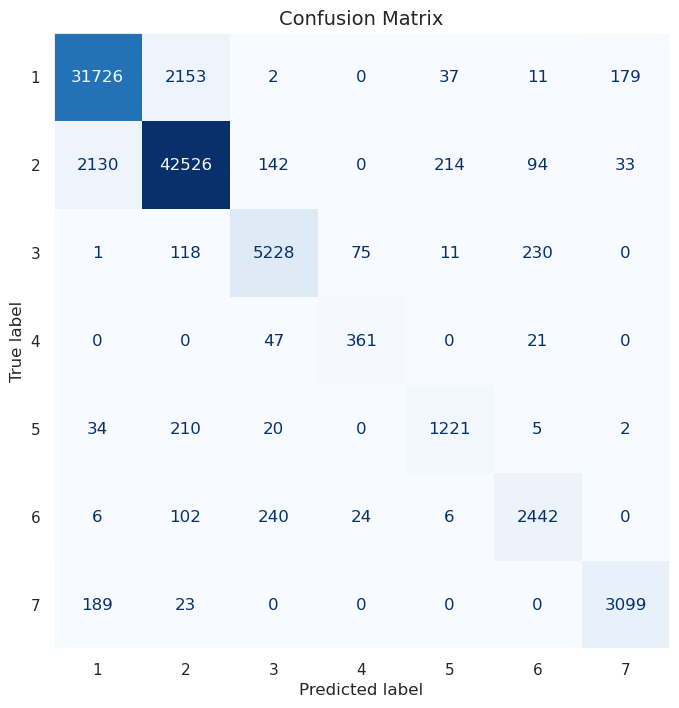

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay
plt.rcParams["axes.grid"] = False
plt.rcParams["figure.figsize"] = (8,8)

def view_confusion_matrix(y_test, y_pred):
    fig, ax = plt.subplots(1,1)
    ax.title.set_text("Confusion Matrix")
    ax.title.set_fontsize("14")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues', colorbar=False)
    plt.show()

view_confusion_matrix(y_test, y_pred)

The confusion matrix shows that in the worst case scenarios, the number of incorrect predictions made by the model is an order of magnitue lower than the number of correct predictions for any given class. We expect this performance to improve by using ensemble methods. 

ScikitLearn allows us to view some metrics of the trained decision tree, for example, we can observe the first few tiers of the decision tree to know what the most informative features are for a first order estimation. 

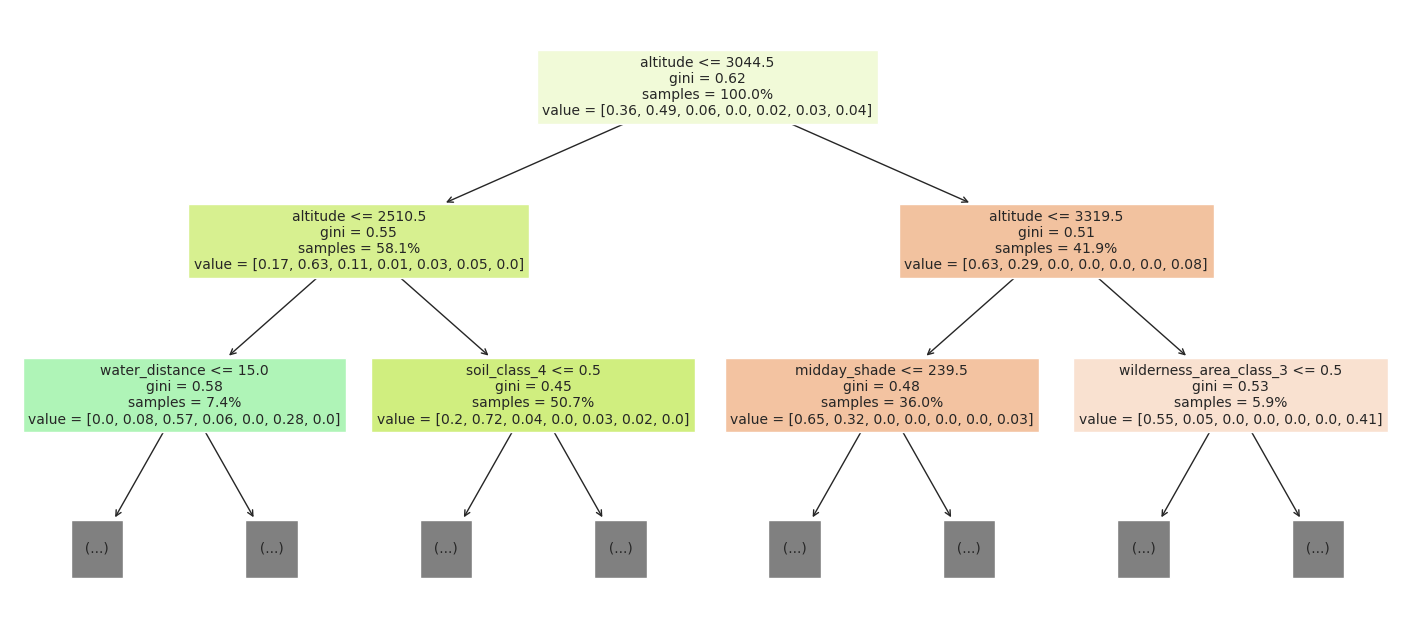

In [13]:
plt.rcParams["figure.figsize"] = (18,8)
fig, axs = plt.subplots(1,1)

plot_tree(dt, max_depth=2, precision=2, feature_names=ready_X.columns, filled=True, proportion=True, fontsize=10, ax=axs)
plt.show()

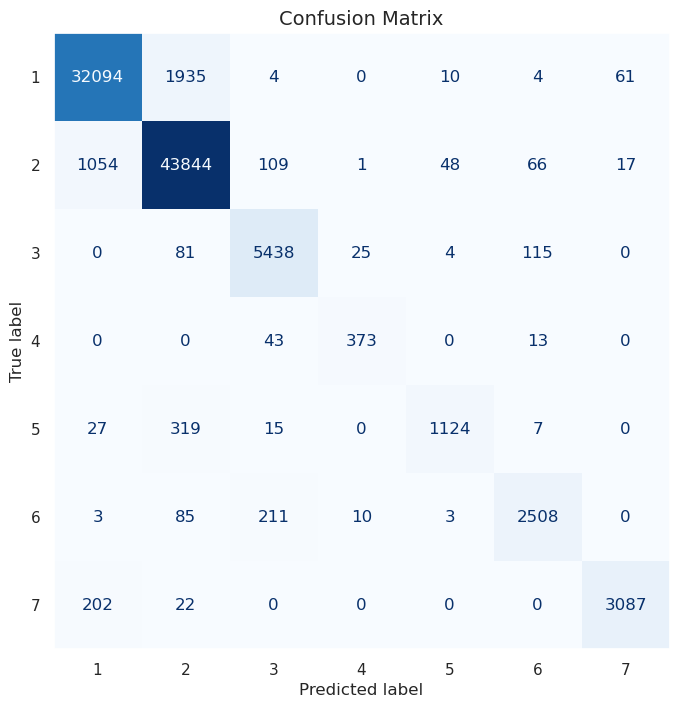

In [14]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

y_pred = train_with(x_train, y_train, rf)

view_confusion_matrix(y_test, y_pred)

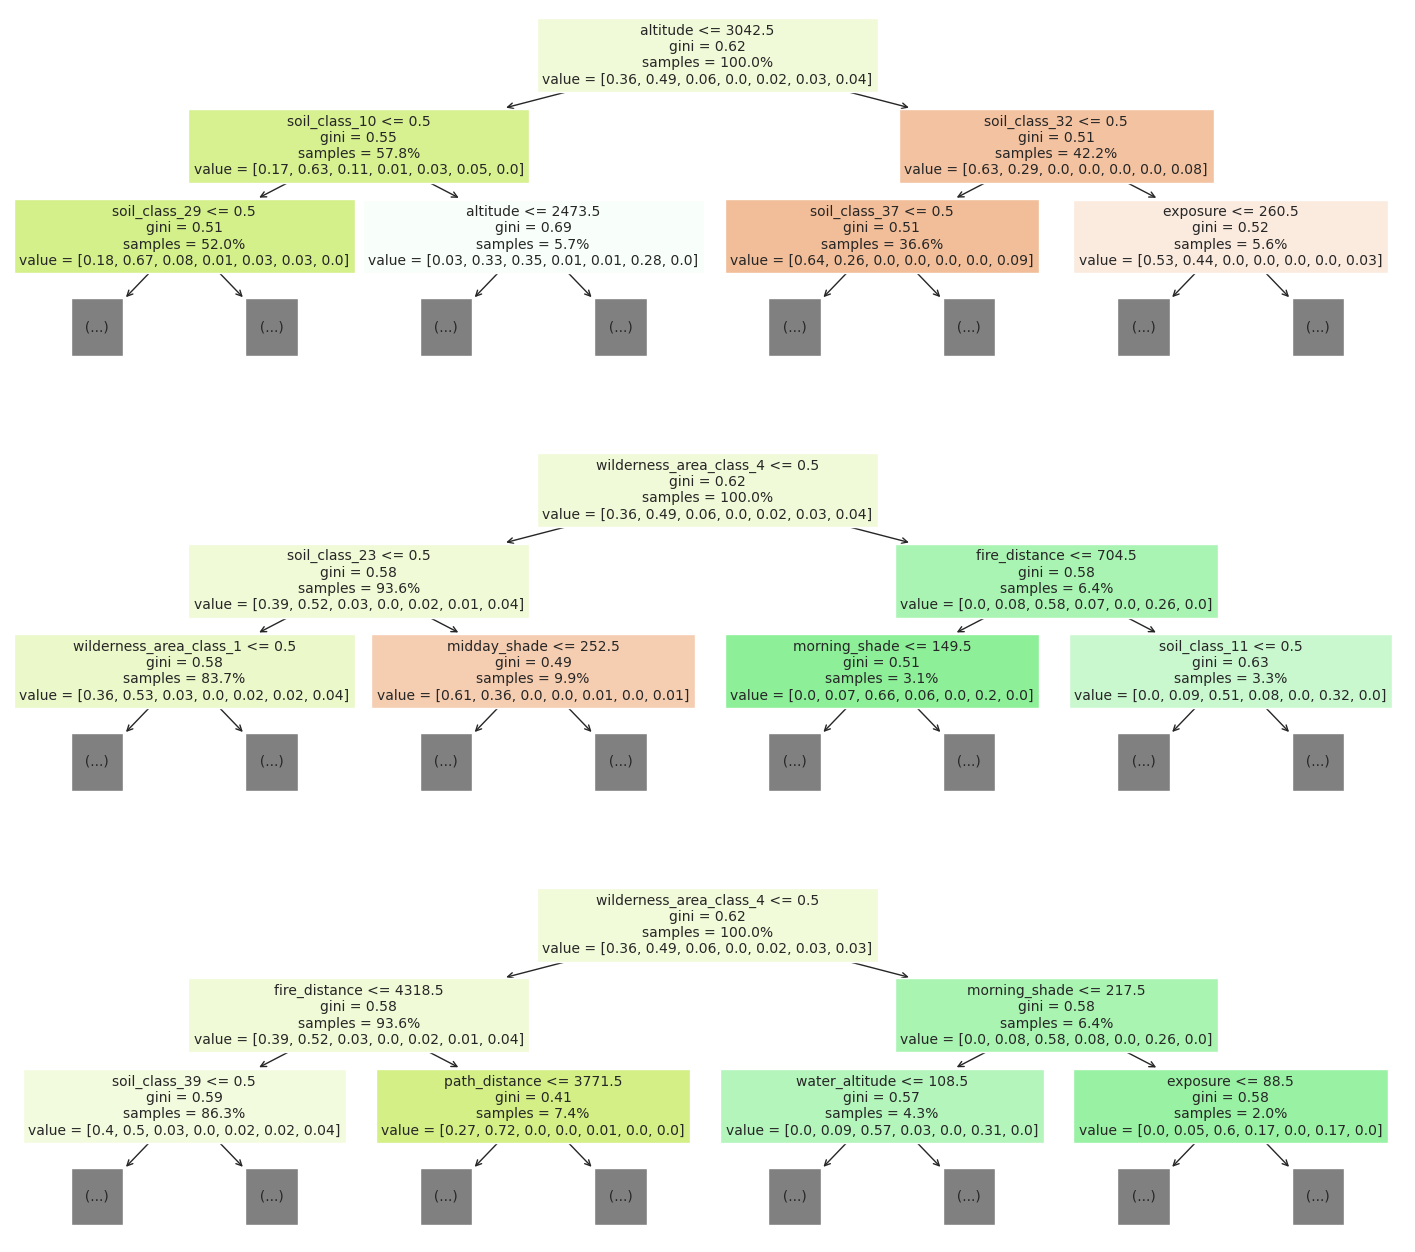

In [15]:
plt.rcParams["figure.figsize"] = (18,16)
fig, axs = plt.subplots(3,1)

for i in range(0,3):
    plot_tree(rf.estimators_[i], max_depth=2, precision=2, feature_names=ready_X.columns, filled=True, proportion=True, fontsize=10, ax=axs[i])

plt.show()